# Analyze controls on AARs/ELAs using ERA-derived climate conditions and machine learning models

In [5]:
# Import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import os
from tqdm.auto import tqdm
import sys
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

### Define paths in directory

In [6]:
# define path to study-sites/
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'

# define path to snow-cover-mapping-application/
base_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application')

# path to save output figures
figures_out_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application', 'figures')

# Load necessary functions
sys.path.insert(1, os.path.join(base_path, 'functions'))
import model_analyze_utils as f

### Construct and/or update training data

In [7]:
# define path and file name of training data
training_data_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application', 'inputs-outputs')
training_data_fn = 'snowline_timeseries_full_training_data.csv'

# load training data from file
training_data_df = f.construct_update_training_data(study_sites_path, training_data_path, training_data_fn)

# remove NaNs and reset index
training_data_df.dropna(inplace=True)
training_data_df.reset_index(drop=True, inplace=True)
training_data_df

Number of sites in file = 186
Training dataset already exists in directory, loading...
Adding new sites to training dataset...


  0%|          | 0/3 [00:00<?, ?it/s]

Boulder
RGI60-01.19725
RGI60-02.00556
Training data re-saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/inputs-outputs/snowline_timeseries_full_training_data.csv


,site_name,Date,AAR,ELA_from_AAR_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe,Mean_Annual_Air_Temp_Range,Mean_Annual_Precipitation_Max,PA_Ratio,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Hypsometric_Index,Hypsometric_Index_Category
0,Blue,2013-09-12,0.437856,1970.00,1083.073924,2.063305,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
1,Blue,2013-09-19,0.447500,1954.96,1145.346363,2.086689,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
2,Blue,2013-10-14,0.817829,1591.00,1194.868455,0.062328,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
3,Blue,2014-05-01,0.925804,1481.00,30.896912,1.545164,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
4,Blue,2014-06-02,0.893074,1526.00,164.490870,1.694039,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49676,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy
49677,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy
49678,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy
49679,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy


## Subset the training data: sample conditions for median week of minimum AAR in each subregion

In [9]:
# define path and file name for training data subset
training_data_subset_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application', 'inputs-outputs')
training_data_subset_fn = 'snowline_timeseries_subset_training_data.csv'

# load training data subset from file
training_data_subset_df = f.subset_training_data(training_data_df, training_data_subset_path, training_data_subset_fn)

# remove NaNs and reset index
training_data_subset_df.dropna(inplace=True)  
training_data_subset_df.reset_index(drop=True, inplace=True)
training_data_subset_df

Training data subset exists in directory, loading...


,site_name,Date,AAR,ELA_from_AAR_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe,Mean_Annual_Air_Temp_Range,Mean_Annual_Precipitation_Max,PA_Ratio,O1Region,...,Area,Zmin,Zmax,Zmed,Slope,Aspect,Hypsometric_Index,Hypsometric_Index_Category,Week,Year
0,Gulkana,2017-08-08,0.218374,2047.740000,359.303035,0.494364,41.578626,0.874576,9.448763,1.0,...,17.567,1162,2438,1858,14.0,172,-1.140053,Equidimensional,32,2017
1,Gulkana,2019-08-08,0.490068,1880.940000,466.440201,0.677443,41.578626,0.874576,9.448763,1.0,...,17.567,1162,2438,1858,14.0,172,-1.140053,Equidimensional,32,2019
2,Gulkana,2019-08-08,0.384614,1931.120000,466.440201,0.677443,41.578626,0.874576,9.448763,1.0,...,17.567,1162,2438,1858,14.0,172,-1.140053,Equidimensional,32,2019
3,Gulkana,2019-08-08,0.453814,1897.320000,466.440201,0.677443,41.578626,0.874576,9.448763,1.0,...,17.567,1162,2438,1858,14.0,172,-1.140053,Equidimensional,32,2019
4,Gulkana,2020-08-04,1.000000,1252.222656,254.612514,0.953177,41.578626,0.874576,9.448763,1.0,...,17.567,1162,2438,1858,14.0,172,-1.140053,Equidimensional,32,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,Sperry,2021-09-23,0.607843,2423.390000,1303.139502,0.976630,47.435399,0.895949,6.630013,2.0,...,1.281,2248,2761,2383,18.9,345,2.971223,Very bottom heavy,38,2021
1412,Sperry,2021-09-25,0.197710,2565.320000,1316.074857,0.976631,47.435399,0.895949,6.630013,2.0,...,1.281,2248,2761,2383,18.9,345,2.971223,Very bottom heavy,38,2021
1413,Sperry,2021-09-25,0.785018,2373.290000,1316.074857,0.976631,47.435399,0.895949,6.630013,2.0,...,1.281,2248,2761,2383,18.9,345,2.971223,Very bottom heavy,38,2021
1414,Sperry,2022-09-25,0.071085,2688.310000,1218.035440,1.040040,47.435399,0.895949,6.630013,2.0,...,1.281,2248,2761,2383,18.9,345,2.971223,Very bottom heavy,38,2022


## Plot pairplot of training data

In [ ]:
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
df = training_data_df.copy()
# change column names for plotting
df['$\Sigma$PDDs'] = df['Cumulative_Positive_Degree_Days']
df['$\Sigma$Snowfall'] = df['Cumulative_Snowfall_mwe']
df['Hyps. Index'] = df['Hypsometric_Index']
df['ELA [m]'] = df['ELA_from_AAR_m']
feature_cols = ['AAR', 'ELA [m]', '$\Sigma$PDDs', '$\Sigma$Snowfall', 
                'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Hyps. Index', 'Mean_Annual_Air_Temp_Range', 'Mean_Annual_Precipitation_Max']
fig = sns.pairplot(df, vars=feature_cols, corner=True, diag_kind='kde', hue='AAR')

plt.show()

# save figure
if 'Area' in feature_cols:
    fig_fn = os.path.join(figures_out_path, 'training_data_pairplot.png')
else:
    fig_fn = os.path.join(figures_out_path, 'training_data_climate_vars_pairplot.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Define feature columns and labels

In [10]:
# columns to use for prediction in training data
feature_columns = [
                   'Cumulative_Positive_Degree_Days', 
                   'Cumulative_Snowfall_mwe', 
                   # 'PA_Ratio',
                   'Hypsometric_Index',
                   'Area', 
                   # 'Zmin', 
                   # 'Zmax', 
                   'Zmed', 
                   'Slope', 
                   'Aspect',
                   'Mean_Annual_Air_Temp_Range',
                   'Mean_Annual_Precipitation_Max']
# how to display each feature column in plots, etc.
feature_columns_display = [
                   '$\Sigma$PDDs', 
                   '$\Sigma$Snowfall [m.w.e.]', 
                   # 'P / \sqrt(A)',
                   'Hypsometric Index',
                   'Area', 
                   # 'Z$_{min}$ [m]', 
                   # 'Z$_{max}$ [m]', 
                   'Z$_{med}$', 
                   'Slope', 
                   'Aspect',
                   'Mean annual air temperature range [$^{\circ}$C]',
                   'Mean annual $\Sigma$Precipitation [m.w.e.]']
# variable to predict
labels = ['AAR']


## Define supervised machine learning models to test


See the [SciKitLearn Classifier comparison page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) for more models, etc.

In [11]:
# Models
models = [
    LinearRegression(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    SVR(),
    GradientBoostingRegressor(),
    Ridge()
]

# Model names (used for plotting, etc.)
model_names = [
    "Linear Regression",
    "Random Forest Regression",
    "Decision Tree Regression",
    "Support Vector Regression",
    "Gradient Boosting Regression",
    "Ridge Regression"
]


# Train and test machine learning models using K-folds cross-validation, conduct permutation feature importance

## One model for all subregions

In [ ]:
# -----Determine best model
out_path = os.path.join(base_path, 'inputs-outputs')
best_model_fn = 'best_model_all_regions.joblib'
best_model, X, y = f.determine_best_model(training_data_subset_df, models, model_names, 
                                          feature_columns, labels, out_path, best_model_fn)

# -----Assess model feature importances
importances_fn = 'best_model_all_regions_feature_importances.csv'
figure_fn = 'best_model_all_regions_feature_importances.png'
feature_importances = f.assess_model_feature_importances(best_model, X, y, feature_columns, feature_columns_display, 
                                                         out_path, importances_fn, figures_out_path, figure_fn)


### Tune the hyperparameters for the Random Forest Regression model

Adapted from [Will Koehrsen's blog post](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) and code package and [here](https://pyimagesearch.com/2021/05/17/introduction-to-hyperparameter-tuning-with-scikit-learn-and-python/). 

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import time 

# -----Define function for conducting the grid search
def grid_search(X_train, X_test, y_train, y_test, parameters):
    # start timer
    t1 = time.time()
    
    # Generate and evaluate the BASE model with no hyperparameter tuning
    rf = RandomForestRegressor(random_state = 42)
    rf.fit(X_train, y_train)
    base_score = rf.score(X_test, y_test)
    
    # Generate the grid search model
    # rf = RandomForestRegressor(random_state = 42)
    grid_search = GridSearchCV(estimator=rf, param_grid=parameters, 
                               cv=3, n_jobs=-1, verbose=1, return_train_score=True)
    # fit the model
    grid_search.fit(X_train, y_train)
    
    # print best parameters
    best_params = grid_search.best_params_
    print(best_params)

    # evaluate best estimator
    best_model = grid_search.best_estimator_
    score = best_model.score(X_test, y_test)
    print('Score of best estimator = ', score)
    print('Score improvement = ', score - base_score)

    # stop timer
    t2 = time.time()
    print('Time elapsed = ', np.round((t2-t1) / 60, 2), ' min')

    return best_params, best_model

# -----Conduct a Grid Search of parameter values, determine the best ones
# Split X and y into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# -----ITERATION 1
# Define ranges for hyperparameters to test
parameters = {'n_estimators': [int(x) for x in np.linspace(1, 500, num = 3)],  # Number of trees
              'max_depth': [int(x) for x in np.linspace(0, 100, num = 3)],  # Maximum number of levels in tree
              'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
              'bootstrap': [True, False]  # Method of selecting samples for training each tree
             }
best_params, best_model_tuned = grid_search(X_train, X_test, y_train, y_test, parameters)

In [ ]:
# -----ITERATION 2
# Define ranges for hyperparameters to test
parameters = {'n_estimators': [int(x) for x in np.linspace(100, 300, num = 5)],  # Number of trees
              'max_depth': [int(x) for x in np.linspace(30, 70, num = 5)],  # Maximum number of levels in tree
              'min_samples_split': [2, 3, 4],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1],  # Minimum number of samples required at each leaf node
              'bootstrap': [True]  # Method of selecting samples for training each tree
             }
best_params, best_model_tuned = grid_search(X_train, X_test, y_train, y_test, parameters)

In [ ]:
# -----ITERATION 3
# Define ranges for hyperparameters to test
parameters = {'n_estimators': [int(x) for x in np.linspace(100, 200, num = 11)],  # Number of trees
              'max_depth': [int(x) for x in np.linspace(20, 40, num = 11)],  # Maximum number of levels in tree
              'min_samples_split': [3],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1],  # Minimum number of samples required at each leaf node
              'bootstrap': [True]  # Method of selecting samples for training each tree
             }
best_params, best_model_tuned = grid_search(X_train, X_test, y_train, y_test, parameters)

In [ ]:
# -----ITERATION 4
# Define ranges for hyperparameters to test
parameters = {'n_estimators': [int(x) for x in np.linspace(140, 160, num = 11)],  # Number of trees
              'max_depth': [int(x) for x in np.linspace(20, 24, num = 5)],  # Maximum number of levels in tree
              'min_samples_split': [3],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1],  # Minimum number of samples required at each leaf node
              'bootstrap': [True]  # Method of selecting samples for training each tree
             }
best_params, best_model_tuned = grid_search(X_train, X_test, y_train, y_test, parameters)

In [ ]:
# -----ITERATION 5
# Define ranges for hyperparameters to test
parameters = {'n_estimators': [int(x) for x in np.linspace(146, 150, num = 5)],  # Number of trees
              'max_depth': [22],  # Maximum number of levels in tree
              'min_samples_split': [3],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1],  # Minimum number of samples required at each leaf node
              'bootstrap': [True]  # Method of selecting samples for training each tree
             }
best_params, best_model_tuned = grid_search(X_train, X_test, y_train, y_test, parameters)

### Save the best model

In [ ]:
best_model_tuned_fn = os.path.join(base_path, 'inputs-outputs', 'best_model_all_regions_tuned.joblib')
dump(best_model_tuned, best_model_tuned_fn)
print('Best model saved to file:', best_model_tuned_fn)

### Plot model predictions for each pair of features 

In [ ]:
# Load best model from file
best_model_tuned_fn = os.path.join(base_path, 'inputs-outputs', 'best_model_all_regions_tuned.joblib')
best_model_tuned = load(best_model_tuned_fn)

# Determine how many subplots and rows are needed based on the number of feature columns
n_columns = len(feature_columns)-2
n_rows = len(feature_columns)-2

# Set up figure
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(n_rows, n_columns, figsize=(4*n_columns, 4*n_rows))
cmp = 'viridis'

# Use mean of all feature columns for baseline
input_df = pd.DataFrame()
for feature_column in feature_columns:
    input_df[feature_column] = [X[feature_column].mean()]

# Iterate over each combination of feature columns
for i, column1 in enumerate(feature_columns[0:-1]):
    # define range of values to test for column 1
    column1_range = list(np.linspace(X[column1].min(), X[column1].max(), num=10))

    columns2 = feature_columns[i+1:-1]
    columns2.reverse()
    for j, column2 in enumerate(columns2):
        # define range of values to test for column 2
        column2_range = list(np.linspace(X[column2].min(), X[column2].max(), num=10))

        # grab model predictions for each combination of parameters in the ranges
        predictions = np.zeros((len(column1_range), len(column2_range)))
        for k in range(0,len(column1_range)):
            for l in range(0, len(column2_range)):
                # change feature column values
                input_df_adj = input_df.copy()
                input_df_adj[column1] = column1_range[k]
                input_df_adj[column2] = column2_range[l]
                # make model prediction
                predictions[k,l] = best_model_tuned.predict(input_df_adj[feature_columns])
                # ROWS = column1 = y
                # COLUMNS = column2 = x

        # plot results
        ax[n_rows-1-i,j].imshow(np.flipud(predictions), cmap=cmp, clim=(0.4, 0.8), aspect=np.max(column2_range)/np.max(column1_range),
                                extent=(np.min(column2_range), np.max(column2_range), 
                                        np.min(column1_range), np.max(column1_range)))
        ax[n_rows-1-i,j].scatter(X[column2], X[column1], c=y.values, cmap=cmp, vmin=0.4, vmax=0.8, edgecolors='k')
        if j==0:
            ax[n_rows-1-i,j].set_ylabel(column1)
        if i==n_rows-1:
            ax[n_rows-1-i,j].set_xlabel(column2)
        ax[n_rows-1-i,j].grid()

# add xlabels on bottom row
# feature_columns_labels = feature_columns.copy()
# feature_columns_labels.reverse()
# for j, label in enumerate(feature_columns_labels):
#     ax[n_rows-1, j].set_xlabel(label)

# remove empty axes
num_del = 1
for i in range(0, n_rows-1):
    for j in range(num_del, n_columns):
        fig.delaxes(ax[i,j])
    num_del += 1      

fig.tight_layout()
plt.show()
        

## Separate model for each subregion

In [ ]:
# -----Grab list of all unique regions and subregions in dataset
unique_subregion_counts = training_data_subset_df[['O1Region', 'O2Region']].value_counts().reset_index(name='count')
unique_subregion_counts = unique_subregion_counts.sort_values(by=['O1Region', 'O2Region']).reset_index(drop=True)
unique_subregions = unique_subregion_counts[['O1Region', 'O2Region']].values
unique_subregion_counts

In [ ]:
# -----Iterate over unique subregions
for o1region, o2region in unique_subregions:
    
    # subset training data to subregion
    training_subregion_df = training_data_subset_df.loc[(training_data_subset_df['O1Region']==o1region) 
                                                        & (training_data_subset_df['O2Region']==o2region)]
    # grab subregion name and color for plotting
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    subregion_name_save = subregion_name.replace('.','').replace(' ','') # remove periods and spaces for saving

    print('----------')
    print(subregion_name)
    print('----------')

    # -----Determine best model
    out_path = os.path.join(base_path, 'inputs-outputs')
    best_model_fn = 'best_model_' + subregion_name_save + '.joblib'
    best_model, X, y = f.determine_best_model(training_subregion_df, models, model_names, 
                                              feature_columns, labels, out_path, best_model_fn)
    
    # -----Assess model feature importances
    importances_fn = 'best_model_' + subregion_name_save + '_feature_importances.csv'
    figure_fn = 'best_model_' + subregion_name_save + '_feature_importances.png'
    feature_importances = f.assess_model_feature_importances(best_model, X, y, feature_columns, feature_columns_display, 
                                                             out_path, importances_fn, figures_out_path, figure_fn)
    print(' ')

## Plot all feature importances on one figure

In [ ]:
# Set up figure
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(6, 2, figsize=(18, 18))
ax = ax.flatten()

# grab all feature importance file names
feature_importances_fns = sorted(glob.glob(os.path.join(base_path, 'inputs-outputs', 
                                                        'best_model_*feature_importances.csv')))
# iterate over file names
for feature_importances_fn in feature_importances_fns:

    # load feature importances from file
    feature_importances = pd.read_csv(feature_importances_fn)
    subregion_name = os.path.basename(feature_importances_fn).split('best_model_')[1].split('_feature')[0]
    subregion_name = (subregion_name.replace('NR', 'N. R').replace('NC', 'N. C').replace('SR', 'S. R').replace('SC', 'S. C')
                      .replace('CR', 'C. R').replace('StEliasMtns', 'St. Elias Mtns.').replace('CoastR', 'Coast R')
                      .replace('WChugachMtns', 'W. Chugach Mtns.').replace('AlaskaR', 'Alaska R'))
    
    # determine which axis to plot on
    if subregion_name=='Aleutians':
        j = 0
        color = '#6d9c43'
    elif subregion_name=='Alaska Range':
        j = 3
        color = '#1f78b4'
    elif subregion_name=='W. Chugach Mtns.':
        j = 2
        color = '#264708'
    elif subregion_name=='St. Elias Mtns.':
        j = 4
        color = '#fb9a99'
    elif subregion_name=='N. Coast Ranges':
        j = 6
        color = '#e31a1c'
    elif subregion_name=='N. Rockies':
        j = 7
        color = '#cab2d6'
    elif subregion_name=='N. Cascades':
        j = 8
        color = '#fdbf6f'
    elif subregion_name=='C. Rockies':
        j = 9
        color = '#9657d9'
    elif subregion_name=='S. Cascades':
        j = 10
        color = '#ff7f00'
    elif subregion_name=='S. Rockies':
        j = 11
        color = '#6a3d9a'
    elif subregion_name=='all_regions':
        j = 1
        color = 'k'
        subregion_name = 'All regions'

    # plot
    boxprops = dict(color='k',linewidth=1)
    medianprops = dict(color="#d9d9d9",linewidth=2)
    whiskerprops=dict(color='k', linewidth=2)
    capprops=dict(color='k', linewidth=2)
    bplot = ax[j].boxplot(feature_importances, showfliers=False, 
                          boxprops=boxprops, medianprops=medianprops, 
                          whiskerprops=whiskerprops, capprops=capprops, patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_facecolor(color)          
    if j >= 10:
        ax[j].set_xticklabels(feature_columns_display)
    else:
        ax[j].set_xticklabels([])
    ax[j].set_ylim(-0.01, np.nanmax(feature_importances) * 1.1)
    ax[j].text(5.4, 
              (ax[j].get_ylim()[1] - ax[j].get_ylim()[0])*0.85 + ax[j].get_ylim()[0],
               subregion_name, horizontalalignment='right',
               bbox=dict(facecolor='white', edgecolor='black', pad=3))
    ax[j].grid()

fig.delaxes(ax[5])
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'feature_importances.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Conduct simulations for assessing regional AAR response to changes in terrain parameters

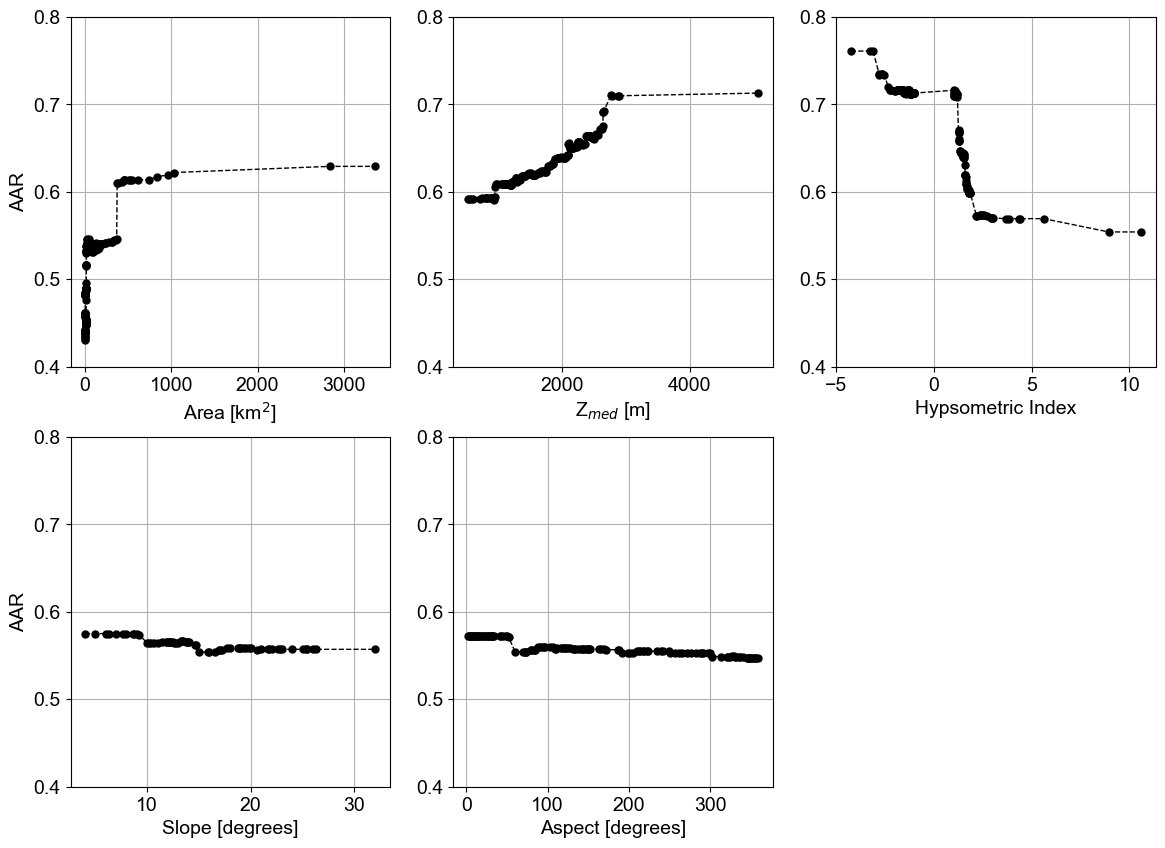

figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/model_AAR_predictions_feature_column_perturbations.png


In [24]:
# -----Determine which columns to perturb
columns = ['Area', 'Zmed', 'Hypsometric_Index', 'Slope', 'Aspect']
columns_display = ['Area [km$^2$]', 'Z$_{med}$ [m]', 'Hypsometric Index', 'Slope [degrees]', 'Aspect [degrees]']

# -----Grab model names
# model_fns = sorted(glob.glob(os.path.join(base_path, 'inputs-outputs', 'best_model*.joblib')))
model_fns = glob.glob(os.path.join(base_path, 'inputs-outputs', 'best_model_all_regions_tuned.joblib'))

# -----Add subregion and color column to training data
training_data_df[['Subregion', 'Color']] = '', ''
for o1region, o2region in training_data_subset_df[['O1Region', 'O2Region']].drop_duplicates().values:
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    training_data_subset_df.loc[(training_data_subset_df['O1Region']==o1region) 
                                 & (training_data_subset_df['O2Region']==o2region), 'Subregion'] = subregion_name
    training_data_subset_df.loc[(training_data_subset_df['O1Region']==o1region) 
                                 & (training_data_subset_df['O2Region']==o2region), 'Color'] = color

# -----Set up figure
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2, 3, figsize=(14,10))
ax = ax.flatten()

# -----Iterate over models
for model_fn in model_fns:
    # determine subregion name
    subregion_name = os.path.basename(model_fn).split('best_model_')[1].split('.joblib')[0]
    subregion_name = (subregion_name.replace('NR', 'N. R').replace('NC', 'N. C').replace('SR', 'S. R').replace('SC', 'S. C')
                      .replace('CR', 'C. R').replace('StEliasMtns', 'St. Elias Mtns.').replace('CoastR', 'Coast R')
                      .replace('WChugachMtns', 'W. Chugach Mtns.').replace('AlaskaR', 'Alaska R'))
        
    # load model
    model = load(model_fn)

    # create dataframe with mean conditions for subregion
    if 'all_regions' in subregion_name:
        training_data_subregion_df = training_data_subset_df.copy()
        color = 'k'
    else:
        training_data_subregion_df = training_data_subset_df.loc[training_data_subset_df['Subregion']==subregion_name]
        color = training_data_subregion_df['Color'].values[0]
    input_df = pd.DataFrame()
    for column in feature_columns:
        input_df[column] = [training_data_subregion_df[column].mean()]
    
    # iterate over columns to perturb
    for i, column in enumerate(columns):
        # determine range of column values to test
        column_range = sorted(training_data_subset_df[column].drop_duplicates().values)
        # iterate over column range
        aars = np.zeros(len(column_range))
        for j, value in enumerate(column_range):
            # set column to value in range
            input_df[column] = value
            # predict AAR with model
            aars[j] = model.predict(input_df[feature_columns])

        # plot results
        if 'all_regions' in subregion_name:
            linewidth=1
            label='All regions'
            markerstyle='o'
            linestyle='--'
        # else:
        #     linewidth=2
        #     label=subregion_name
        #     markerstyle='o'
        #     linestyle='--'
        ax[i].plot(column_range, aars, marker=markerstyle, color=color, markersize=5,
                   linestyle=linestyle, linewidth=linewidth, label=label)

# add axes labels
for axis, column_display in zip(ax, columns_display):
    axis.set_xlabel(column_display)
    axis.set_ylim(0.4, 0.8)
    axis.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
    axis.grid()
ax[0].set_ylabel('AAR')
ax[3].set_ylabel('AAR')
# ax[2].legend(loc='center right', bbox_to_anchor=[0.7, -0.8, 0.2, 0.2])
fig.delaxes(ax[-1])
plt.show()
    
# save figure
fig_fn = os.path.join(figures_out_path, 'model_AAR_predictions_feature_column_perturbations.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Conduct simulations for assessing regional sensitivity to climate perturbations

In [ ]:
# # -----Iterate over unique subregions
# perturb_df = pd.DataFrame()
# for o1region, o2region in unique_subregions:
    
#     # Subset training data to subregion
#     snowlines_subregion = training_data_df.loc[(training_data_df['O1Region']==o1region) & (training_data_df['O2Region']==o2region)]
#     subregion_name, color = f.determine_subregion_name_color(float(o1region), float(o2region))
#     print(subregion_name)

#     # Construct input data
#     input_df = pd.DataFrame()
#     for column in feature_columns:
#         input_df[column] = [snowlines_subregion[column].drop_duplicates().mean()]
#     # predict AAR using input data
#     clf_fn = os.path.join(base_path, 'inputs-outputs', 'best_classifier_' + subregion_name + '.joblib')
#     clf = load(clf_fn)
#     AAR_mean = clf.predict(input_df)[0]
    
#     # predict AAR if 150 additional PDDs
#     input_adj_df = input_df.copy()
#     input_adj_df['Cumulative_Positive_Degree_Days'] = input_adj_df['Cumulative_Positive_Degree_Days'] + 150
#     AAR_PDD_perturb = clf.predict(input_adj_df)[0]

#     # predict AAR if - 10% cumulative snow
#     input_adj_df = input_df.copy()
#     input_adj_df['Cumulative_Snowfall_mwe'] = input_adj_df['Cumulative_Snowfall_mwe'] * 0.9
#     AAR_snowfall_perturb = clf.predict(input_adj_df)[0]

#     # compile in dataframe
#     df = pd.DataFrame({'Subregion Name': [subregion_name],
#                        'Mean conditions AAR': [AAR_mean],
#                        '+150 PPDs AAR': [AAR_PDD_perturb],
#                        '+150 PDDs AAR % change': [(AAR_mean-AAR_PDD_perturb)/AAR_mean * 100],
#                        '-10% snowfall AAR': [AAR_snowfall_perturb],
#                        '-10% snowfall AAR % change': [(AAR_mean-AAR_snowfall_perturb)/AAR_mean * 100]
#                       })
#     perturb_df = pd.concat([perturb_df, df])

# perturb_df.reset_index(drop=True, inplace=True)
# perturb_df['+150 PDDs AAR % change'] = perturb_df['+150 PDDs AAR % change'].apply(np.round)
# perturb_df['-10% snowfall AAR % change'] = perturb_df['-10% snowfall AAR % change'].apply(np.round)

# perturb_df[['Subregion Name', '+150 PDDs AAR % change', '-10% snowfall AAR % change']]

In [ ]:
# # Plot PDDs and AAR for one site as an example
# site_name = 'SouthCascade'
# training_site = training_data_df.loc[training_data_df['site_name']==site_name]
# training_site = training_site.sort_values(by='datetime')

# # load ERA data
# ERA_fn = glob.glob(os.path.join(study_sites_path, site_name, 'ERA', '*.csv'))[0]
# ERA = pd.read_csv(ERA_fn)
# ERA['Date'] = pd.to_datetime(ERA['Date'])

# plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
# fig, ax = plt.subplots(2, 1, figsize=(12,8))
# # AAR
# ax[0].plot(training_site['datetime'], training_site['AAR'], '.k')
# ax[0].grid()
# ax[0].set_xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
# ax[0].set_ylabel('AAR')
# ax[0].set_title('South Cascade Glacier')

# # PDDs and snowfall
# ax[1].bar(ERA['Date'], ERA['Cumulative_Snowfall_mwe'], color='#4eb3d3', width=1)
# ax[1].set_ylabel('$\Sigma$ Snowfall [m.w.e.]', color='#4eb3d3')
# ax[1].set_xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
# ax[1].grid()
# ax[1].tick_params(axis='y', colors='#4eb3d3')
# ax2 = ax[1].twinx()
# ax2.plot(ERA['Date'], ERA['Cumulative_Positive_Degree_Days'], '.m')
# ax2.set_ylabel('$\Sigma$ Positive degree days', color='m')
# ax2.tick_params(axis='y', colors='m')

# plt.show()

# # save figure
# fig_fn = os.path.join(figures_out_path, 'example_time_series_SouthCascadeGlacier.png')
# fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
# print('figure saved to file: ' + fig_fn)